In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7617571396138547792, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15538296484205993736
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2559964600602064639
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15876469556
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2720477774444186018
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
# from sklearn.metrics import log_loss
import sys
# import time
import math
import os
import pandas as pd
# from keras.callbacks import EarlyStopping
import numpy as np
# from glob import glob
# import cv2
# import skimage
# from skimage.transform import resize
from keras.utils.np_utils import to_categorical
# import keras
# from keras import layers
# from keras import models
# from keras import optimizers
# from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input,concatenate
# from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
# from keras.applications.vgg19 import VGG19
from keras.regularizers import l2, l1

import matplotlib.pyplot as plt
# from keras.layers import Input, concatenate
# from keras import optimizers, metrics, models
# from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.3.1
tensorflow Version 2.0.0


In [5]:
batch_size = 64
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)
epochs = 400

In [6]:
print(os.listdir("../input/"))

['payam-thesis', 'full-keras-pretrained-no-top']


In [7]:
# print(os.listdir("../input/full-keras-pretrained-no-top"))

In [8]:
train_dir = '../input/payam-thesis/train/'
test_dir = '../input/payam-thesis/test'

In [9]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [10]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 4611 images belonging to 3 classes.
Found 1152 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [11]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 4611
nb_validation_samples: 1152
nb_test_samples: 765

predict_size_train: 73
predict_size_validation: 18
predict_size_test: 12

 num_classes: 3


In [12]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"

In [13]:
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
from keras.applications import DenseNet121
from keras.applications import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge, NASNetMobile
from keras.applications import MobileNet

In [14]:
input_tensor = Input(shape = input_shape)  

base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
base_model2=MobileNet(input_shape= input_shape,weights=mobilenet_weights, include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [15]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [16]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[18].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[51].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[74].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[101].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[120].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[167].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[215].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[263].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[313].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[334].output
c12 = GlobalAveragePooling2D()(c12) 

c13 = model.layers[376].output
c13 = GlobalAveragePooling2D()(c13) 

c14 = model.layers[291].output
c14 = GlobalAveragePooling2D()(c14) 

c15 = model.layers[305].output
c15 = GlobalAveragePooling2D()(c15) 

c16 = model.layers[311].output
c16 = GlobalAveragePooling2D()(c16) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "densenet201_InceptionResNetV2_descriptors"

In [18]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [19]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [20]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [22]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [34]:
model = Sequential()
model.add(Dense(4096, activation='tanh',kernel_regularizer=l2(1e-05),  bias_regularizer=l2(1e-06), activity_regularizer=l1(0.001)))
model.add(Dense(128, activation='tanh',kernel_regularizer=l2(1e-05),  bias_regularizer=l2(1e-06), activity_regularizer=l1(0.001)))
model.add(Dense(64, activation='tanh',kernel_regularizer=l2(1e-05),  bias_regularizer=l2(1e-06), activity_regularizer=l1(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.8)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

Train on 4611 samples, validate on 1152 samples
Epoch 1/400
 - 1s - loss: 34.4536 - accuracy: 0.5216 - val_loss: 29.5748 - val_accuracy: 0.4314
Epoch 2/400
 - 1s - loss: 20.8205 - accuracy: 0.6278 - val_loss: 23.8093 - val_accuracy: 0.7752
Epoch 3/400
 - 1s - loss: 18.2065 - accuracy: 0.6576 - val_loss: 22.0213 - val_accuracy: 0.9036
Epoch 4/400
 - 1s - loss: 16.8113 - accuracy: 0.6504 - val_loss: 20.3353 - val_accuracy: 0.7127
Epoch 5/400
 - 1s - loss: 15.8087 - accuracy: 0.7044 - val_loss: 20.2684 - val_accuracy: 0.6719
Epoch 6/400
 - 1s - loss: 15.1701 - accuracy: 0.6962 - val_loss: 21.1112 - val_accuracy: 0.4314
Epoch 7/400
 - 1s - loss: 14.6323 - accuracy: 0.6855 - val_loss: 20.8097 - val_accuracy: 0.4314
Epoch 8/400
 - 1s - loss: 14.1736 - accuracy: 0.6827 - val_loss: 20.0303 - val_accuracy: 0.5095
Epoch 9/400
 - 1s - loss: 13.7710 - accuracy: 0.6985 - val_loss: 19.3171 - val_accuracy: 0.4227
Epoch 10/400
 - 1s - loss: 13.4725 - accuracy: 0.7085 - val_loss: 18.7691 - val_accuracy

Epoch 86/400
 - 1s - loss: 8.4725 - accuracy: 0.9512 - val_loss: 14.3892 - val_accuracy: 0.9453
Epoch 87/400
 - 1s - loss: 8.4845 - accuracy: 0.9490 - val_loss: 15.3292 - val_accuracy: 0.4366
Epoch 88/400
 - 1s - loss: 8.5169 - accuracy: 0.9410 - val_loss: 13.4759 - val_accuracy: 0.8915
Epoch 89/400
 - 1s - loss: 8.4590 - accuracy: 0.9536 - val_loss: 14.7201 - val_accuracy: 0.7543
Epoch 90/400
 - 1s - loss: 8.4670 - accuracy: 0.9486 - val_loss: 14.7465 - val_accuracy: 0.8186
Epoch 91/400
 - 1s - loss: 8.4546 - accuracy: 0.9499 - val_loss: 13.9076 - val_accuracy: 0.8802
Epoch 92/400
 - 1s - loss: 8.4007 - accuracy: 0.9540 - val_loss: 15.2535 - val_accuracy: 0.5339
Epoch 93/400
 - 1s - loss: 8.4358 - accuracy: 0.9475 - val_loss: 14.7175 - val_accuracy: 0.6554
Epoch 94/400
 - 1s - loss: 8.4605 - accuracy: 0.9501 - val_loss: 14.6332 - val_accuracy: 0.7682
Epoch 95/400
 - 1s - loss: 8.4119 - accuracy: 0.9553 - val_loss: 15.6477 - val_accuracy: 0.3915
Epoch 96/400
 - 1s - loss: 8.4223 - accu

Epoch 171/400
 - 1s - loss: 8.0638 - accuracy: 0.9777 - val_loss: 14.2152 - val_accuracy: 0.9557
Epoch 172/400
 - 1s - loss: 8.0774 - accuracy: 0.9768 - val_loss: 13.5260 - val_accuracy: 0.9870
Epoch 173/400
 - 1s - loss: 8.0867 - accuracy: 0.9761 - val_loss: 14.4009 - val_accuracy: 0.7951
Epoch 174/400
 - 1s - loss: 8.0897 - accuracy: 0.9720 - val_loss: 15.8123 - val_accuracy: 0.6042
Epoch 175/400
 - 1s - loss: 8.1153 - accuracy: 0.9746 - val_loss: 14.7565 - val_accuracy: 0.8707
Epoch 176/400
 - 1s - loss: 8.0458 - accuracy: 0.9835 - val_loss: 14.4383 - val_accuracy: 0.6398
Epoch 177/400
 - 1s - loss: 8.1402 - accuracy: 0.9705 - val_loss: 13.8793 - val_accuracy: 0.7561
Epoch 178/400
 - 1s - loss: 8.1484 - accuracy: 0.9744 - val_loss: 13.3907 - val_accuracy: 0.7587
Epoch 179/400
 - 1s - loss: 7.9555 - accuracy: 0.9813 - val_loss: 14.9294 - val_accuracy: 0.8411
Epoch 180/400
 - 1s - loss: 8.1373 - accuracy: 0.9731 - val_loss: 13.5085 - val_accuracy: 0.9861
Epoch 181/400
 - 1s - loss: 7.

Epoch 256/400
 - 1s - loss: 8.1567 - accuracy: 0.9835 - val_loss: 13.1278 - val_accuracy: 0.9748
Epoch 257/400
 - 1s - loss: 8.1159 - accuracy: 0.9879 - val_loss: 13.8390 - val_accuracy: 0.9479
Epoch 258/400
 - 1s - loss: 8.3598 - accuracy: 0.9768 - val_loss: 13.5750 - val_accuracy: 0.9523
Epoch 259/400
 - 1s - loss: 8.1903 - accuracy: 0.9866 - val_loss: 13.9275 - val_accuracy: 0.9766
Epoch 260/400
 - 1s - loss: 8.1611 - accuracy: 0.9883 - val_loss: 14.0788 - val_accuracy: 0.9323
Epoch 261/400
 - 1s - loss: 8.1601 - accuracy: 0.9879 - val_loss: 14.3413 - val_accuracy: 0.9271
Epoch 262/400
 - 1s - loss: 8.1694 - accuracy: 0.9874 - val_loss: 13.5732 - val_accuracy: 0.8559
Epoch 263/400
 - 1s - loss: 8.2154 - accuracy: 0.9831 - val_loss: 14.4150 - val_accuracy: 0.6285
Epoch 264/400
 - 1s - loss: 8.1806 - accuracy: 0.9714 - val_loss: 14.0725 - val_accuracy: 0.9479
Epoch 265/400
 - 1s - loss: 8.1488 - accuracy: 0.9885 - val_loss: 14.5684 - val_accuracy: 0.5009
Epoch 266/400
 - 1s - loss: 8.

Epoch 341/400
 - 1s - loss: 8.3014 - accuracy: 0.9879 - val_loss: 13.6760 - val_accuracy: 0.9705
Epoch 342/400
 - 1s - loss: 8.2917 - accuracy: 0.9931 - val_loss: 13.5462 - val_accuracy: 0.9800
Epoch 343/400
 - 1s - loss: 8.3734 - accuracy: 0.9863 - val_loss: 14.5898 - val_accuracy: 0.7448
Epoch 344/400
 - 1s - loss: 8.3083 - accuracy: 0.9900 - val_loss: 13.2781 - val_accuracy: 0.9931
Epoch 345/400
 - 1s - loss: 8.2449 - accuracy: 0.9920 - val_loss: 14.6076 - val_accuracy: 0.9861
Epoch 346/400
 - 1s - loss: 8.3200 - accuracy: 0.9842 - val_loss: 14.4889 - val_accuracy: 0.9531
Epoch 347/400
 - 1s - loss: 8.2619 - accuracy: 0.9944 - val_loss: 13.6344 - val_accuracy: 0.9792
Epoch 348/400
 - 1s - loss: 8.2835 - accuracy: 0.9833 - val_loss: 14.0488 - val_accuracy: 0.9887
Epoch 349/400
 - 1s - loss: 8.0681 - accuracy: 0.9933 - val_loss: 13.5130 - val_accuracy: 0.8837
Epoch 350/400
 - 1s - loss: 8.2237 - accuracy: 0.9911 - val_loss: 14.5860 - val_accuracy: 0.9852
Epoch 351/400
 - 1s - loss: 8.

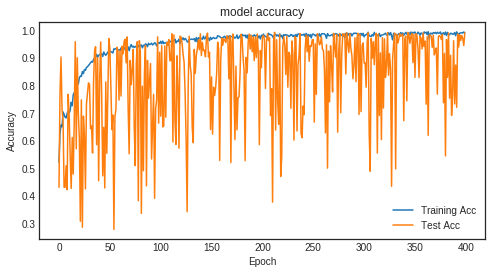

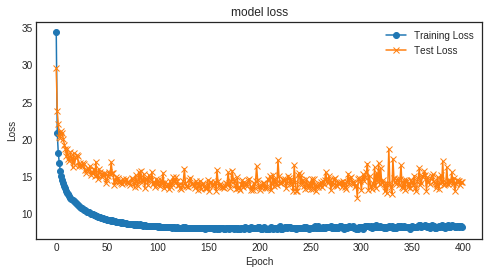

<Figure size 432x288 with 0 Axes>

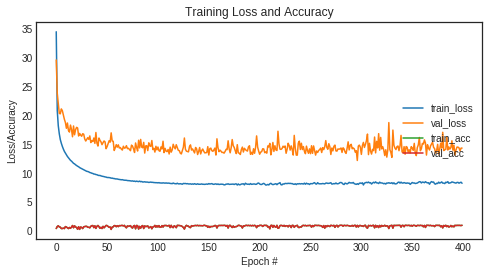

In [35]:
import seaborn
plt.style.use('seaborn-white')
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='lower right')
plt.show()

# summarize history for loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'x-')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')

plt.show()

plt.figure()
plt.figure(figsize=(8,4))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [36]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

1152/1152 [==============================] - 0s 54us/step
Validation Accuracy: 99.1319%
Validation Loss: 14.338954819573296


In [37]:
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9947712418300654


Confusion Matrix
[[329   0   0]
 [  3 208   0]
 [  1   0 224]]


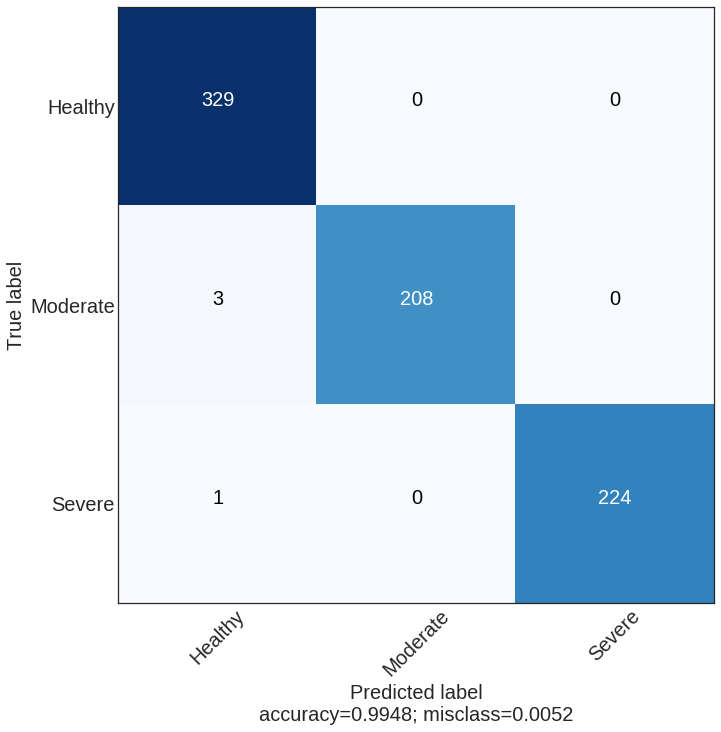

In [38]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[329   0   0]
 [  3 208   0]
 [  1   0 224]]
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       329
    Moderate       1.00      0.99      0.99       211
      Severe       1.00      1.00      1.00       225

    accuracy                           0.99       765
   macro avg       1.00      0.99      0.99       765
weighted avg       0.99      0.99      0.99       765



In [40]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  99.09638554216868
Specificity :  100.0


In [41]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

765/765 [==============================] - 0s 49us/step
Precision =  0.9948340497360105
Recall =  0.9947712418300654
f1_score =  0.9947715439864012


In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9954128440366973


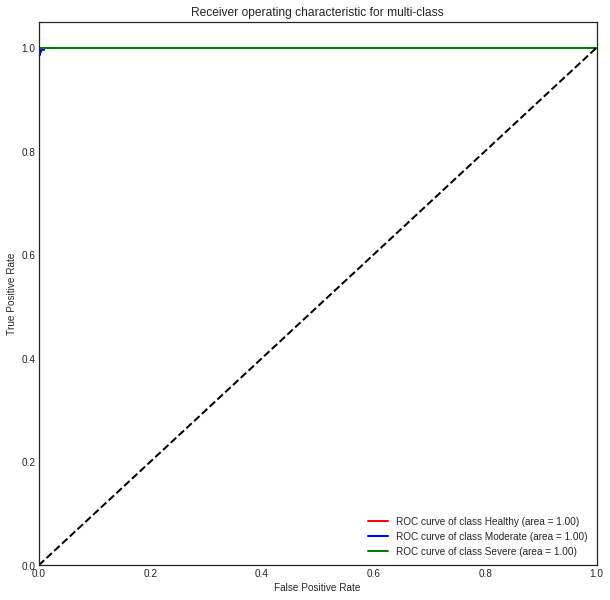

In [43]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2])
y_pred_binary = y_pred_probabilities
n_classes=3
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

In [ ]:
print("Done!")